In [1]:
# Step 1 — Imports & (optional) install xgboost
import sys, subprocess, warnings, time
warnings.filterwarnings("ignore")

# install xgboost if not present
try:
    import xgboost as xgb
except Exception:
    print("Installing xgboost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

# core libs
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import scipy.stats as stats

RANDOM_STATE = 42
print("Imports done.")


Imports done.


In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 2 — Load data & configure target
DATA_PATH = "supply_chain_data.csv"   # update path if needed
TARGET_COL = "Revenue generated"      # change if you want a different target

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
if TARGET_COL not in df.columns:
    raise ValueError(f"Target '{TARGET_COL}' not found in columns.")
# show sample
display(df.head())


Dataset shape: (100, 24)
Columns: ['Product type', 'SKU', 'Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Customer demographics', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Defect rates', 'Transportation modes', 'Routes', 'Costs']


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [3]:
# Initial examination
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Basic statistics
print("\nDescriptive statistics:")
display(df.describe(include='all').T)

# Data types and missing values
print("\nData types and missing values:")
display(pd.DataFrame({
    'dtype': df.dtypes,
    'missing_values': df.isna().sum(),
    'unique_values': df.nunique()
}))

Dataset shape: (100, 24)

First 5 rows:


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632



Descriptive statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Product type,100,3,skincare,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SKU,100,100,SKU0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,100.0,NaN,NaN,NaN,49.462461,31.168193,1.699976,19.597823,51.239831,77.198228,99.171329
Availability,100.0,NaN,NaN,NaN,48.4,30.743317,1.0,22.75,43.5,75.0,100.0
Number of products sold,100.0,NaN,NaN,NaN,460.99,303.780074,8.0,184.25,392.5,704.25,996.0
Revenue generated,100.0,NaN,NaN,NaN,5776.048187,2732.841744,1061.618523,2812.847151,6006.352023,8253.976921,9866.465458
Customer demographics,100,4,Unknown,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock levels,100.0,NaN,NaN,NaN,47.77,31.369372,0.0,16.75,47.5,73.0,100.0
Lead times,100.0,NaN,NaN,NaN,15.96,8.785801,1.0,8.0,17.0,24.0,30.0
Order quantities,100.0,NaN,NaN,NaN,49.22,26.784429,1.0,26.0,52.0,71.25,96.0



Data types and missing values:


,dtype,missing_values,unique_values
Product type,object,0,3
SKU,object,0,100
Price,float64,0,100
Availability,int64,0,63
Number of products sold,int64,0,96
Revenue generated,float64,0,100
Customer demographics,object,0,4
Stock levels,int64,0,65
Lead times,int64,0,29
Order quantities,int64,0,61


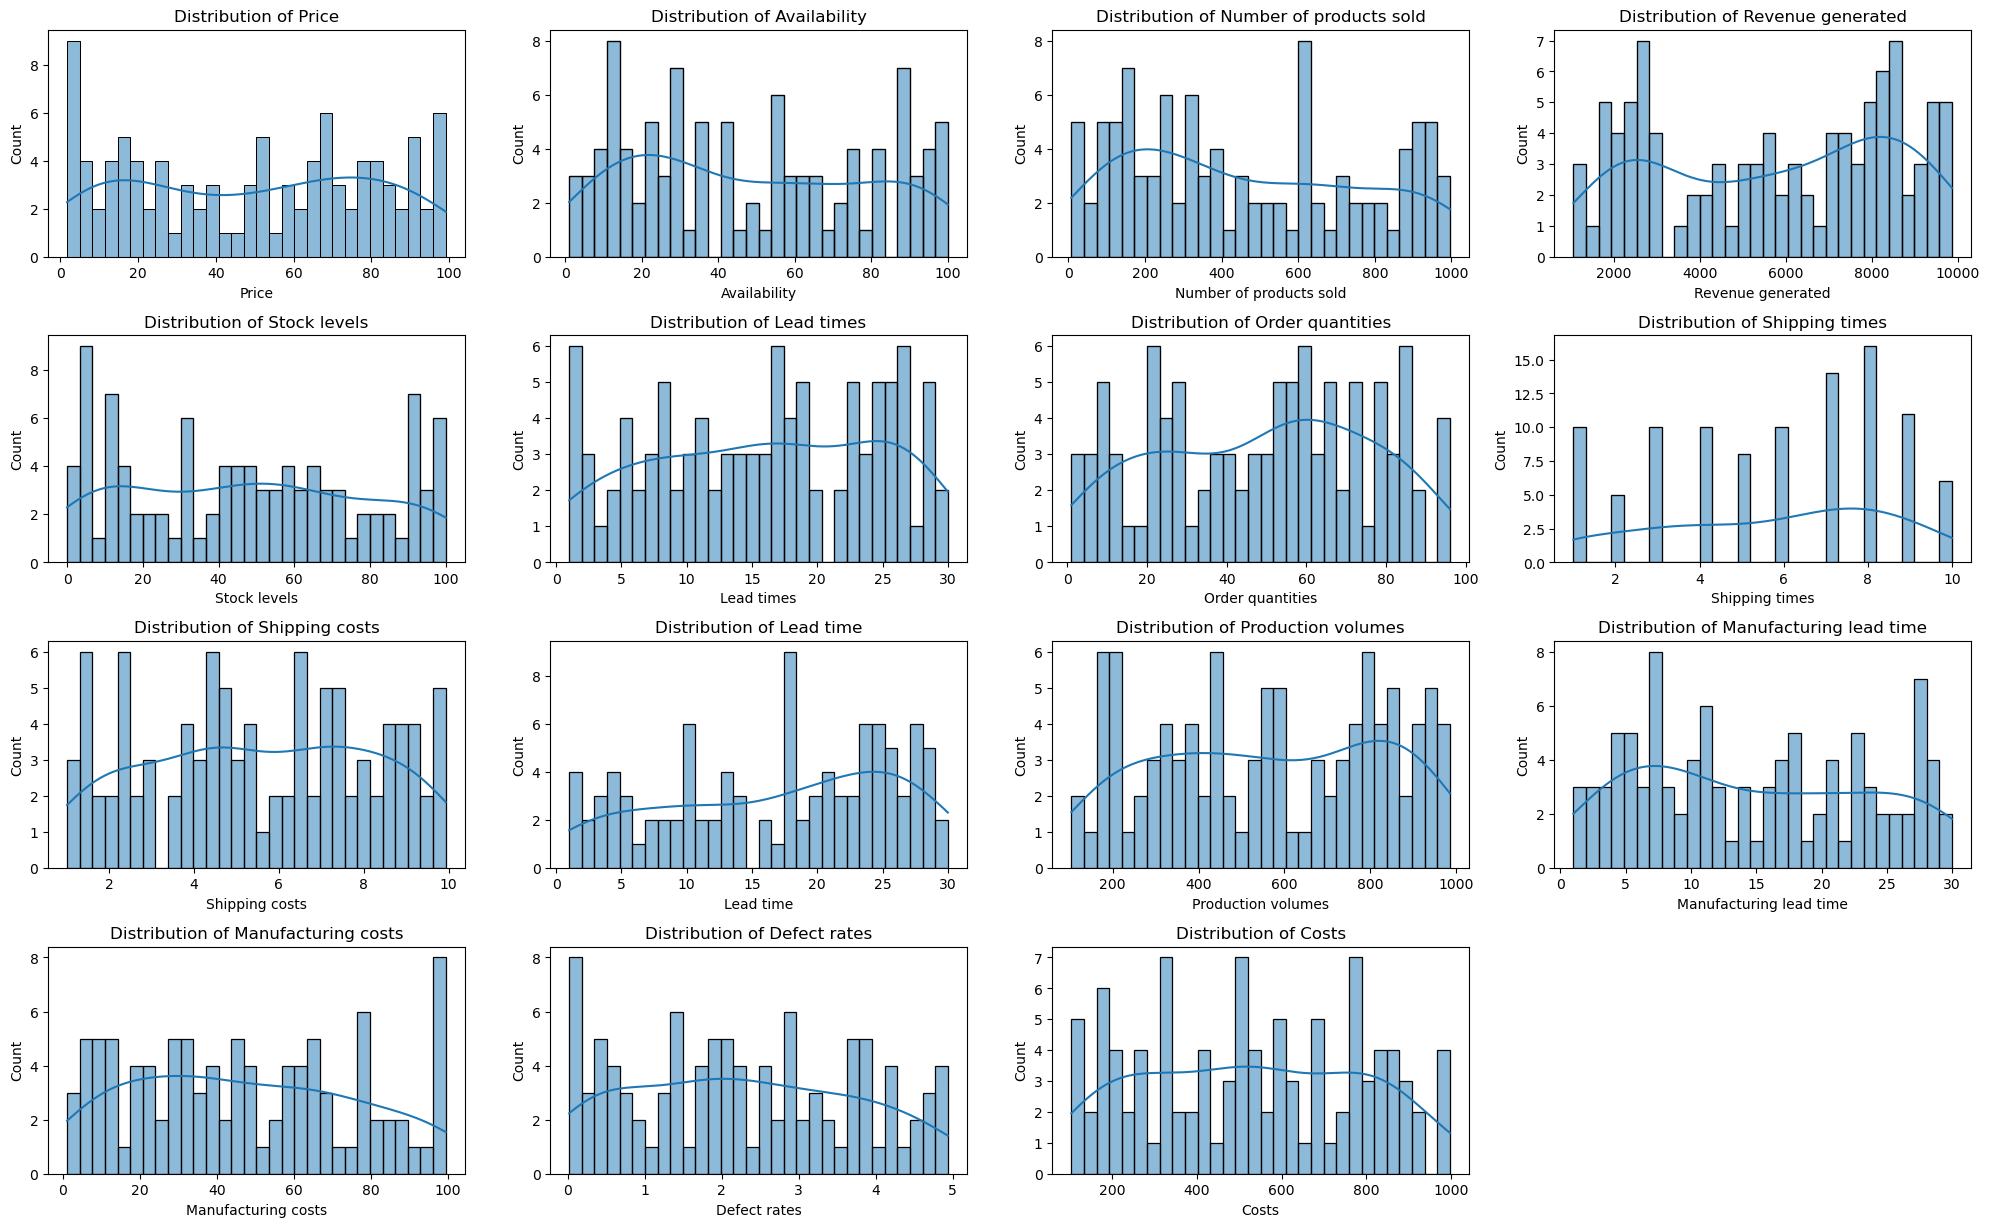

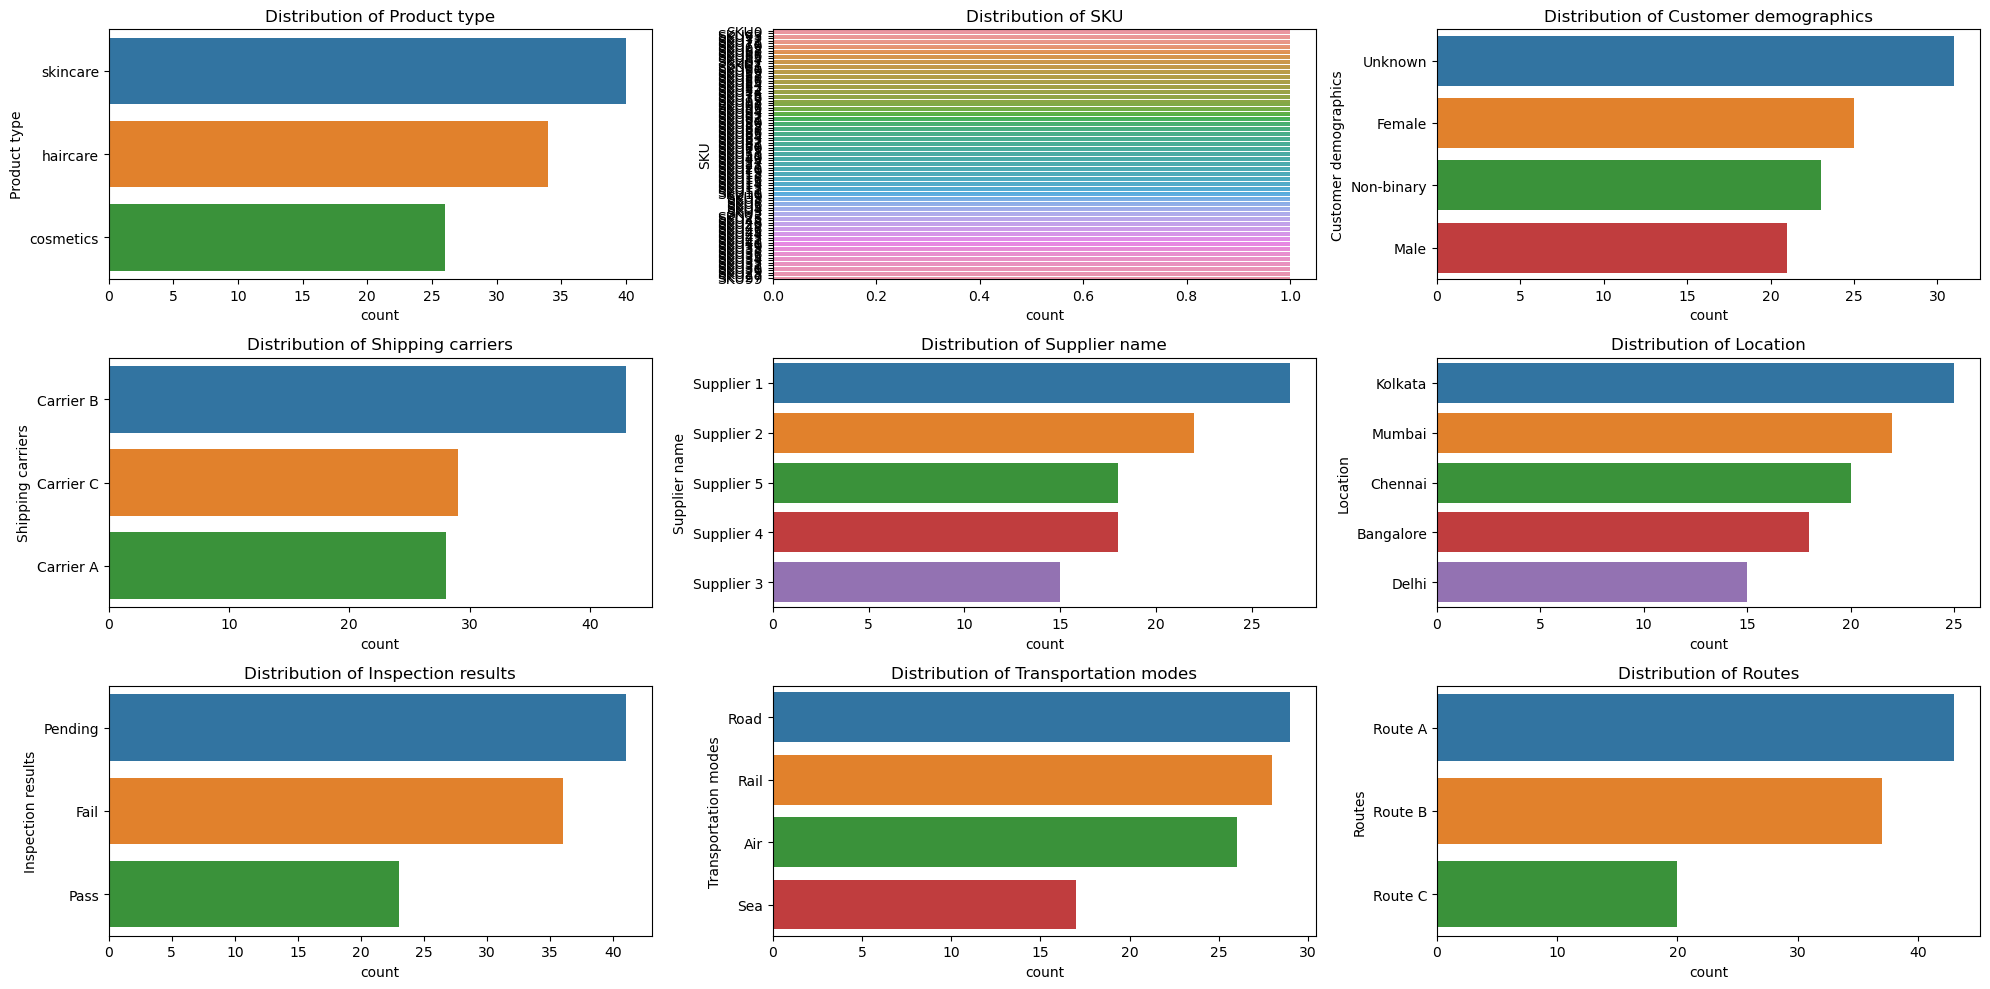

In [6]:
# Numerical features distribution
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

# Categorical features distribution
cat_cols = df.select_dtypes(include=['object']).columns
plt.figure(figsize=(20, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

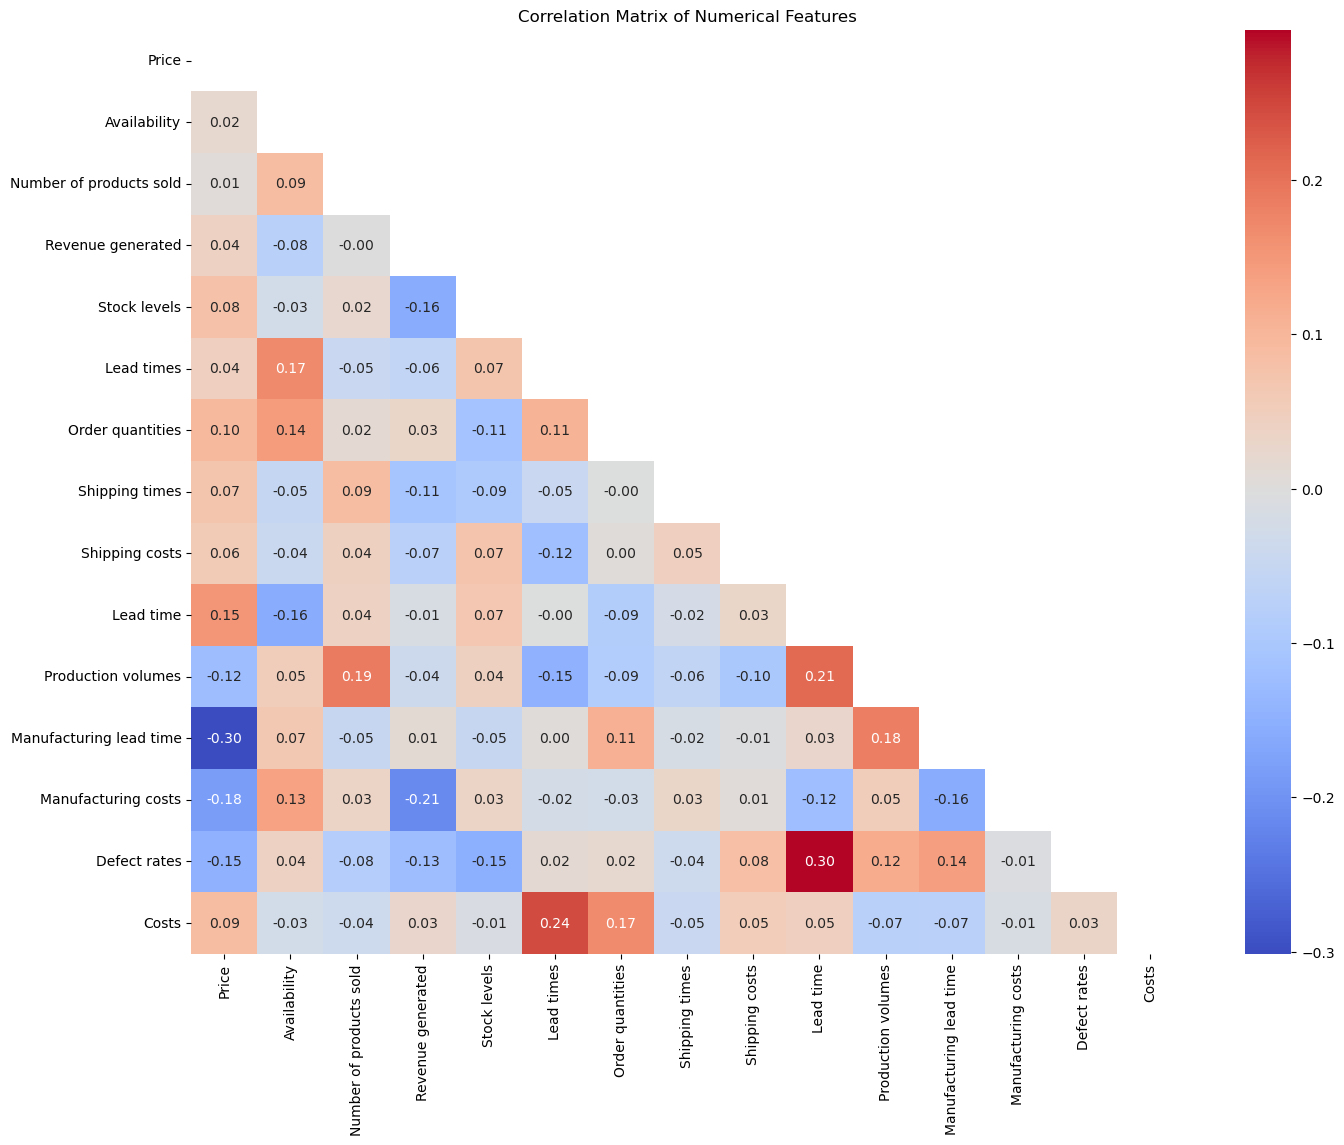

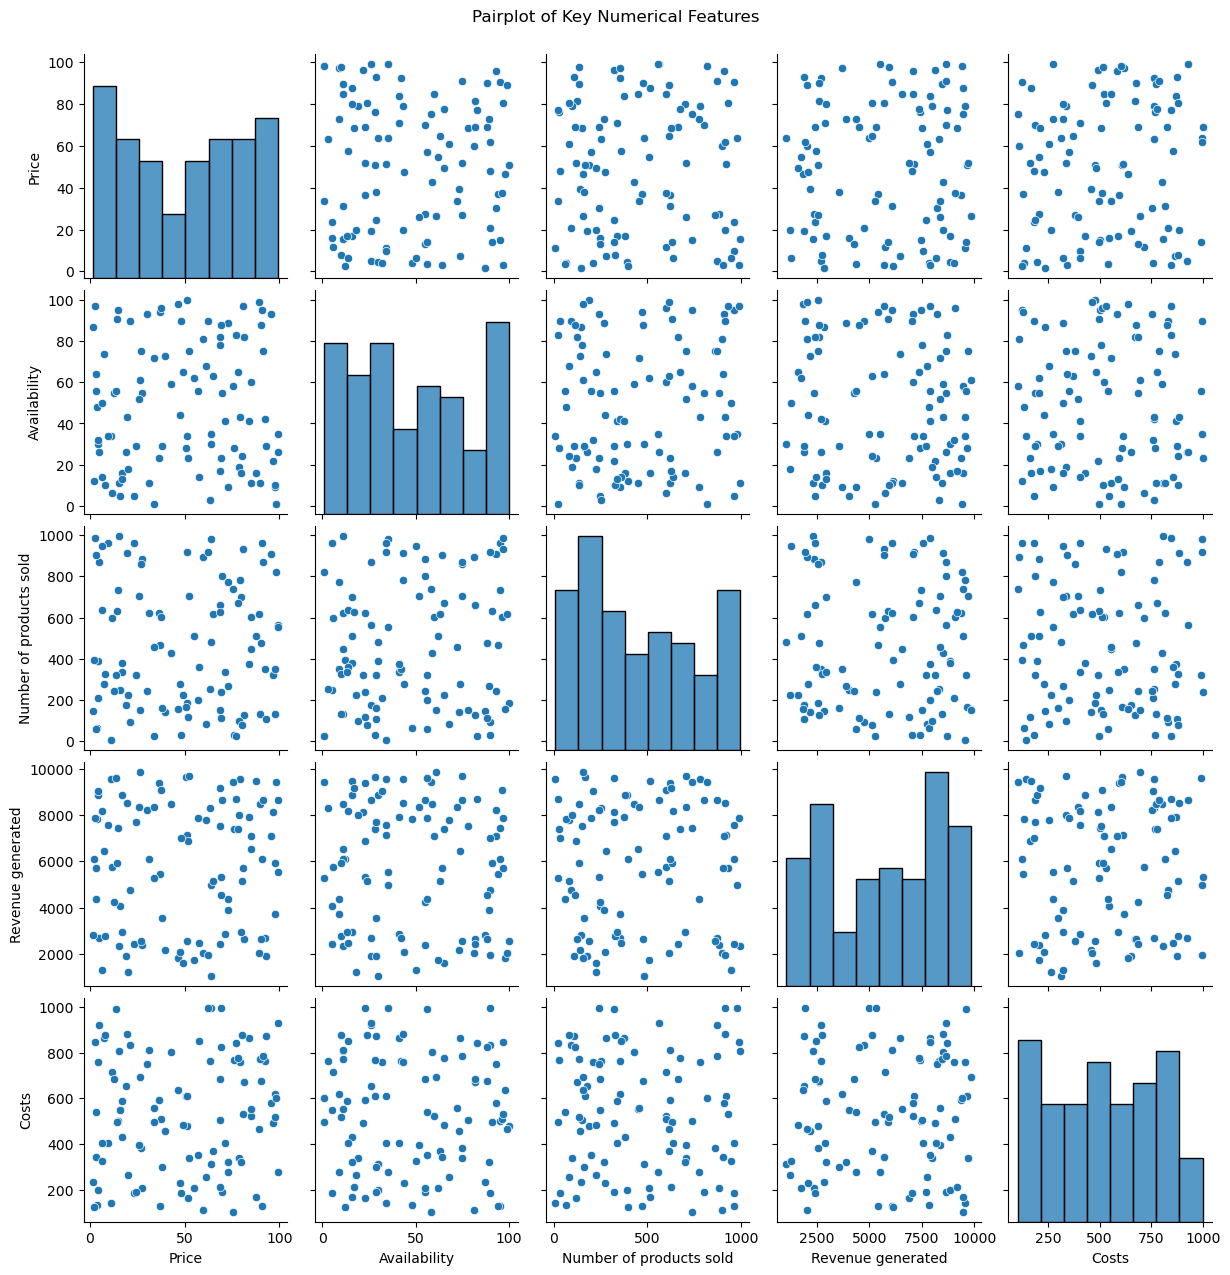

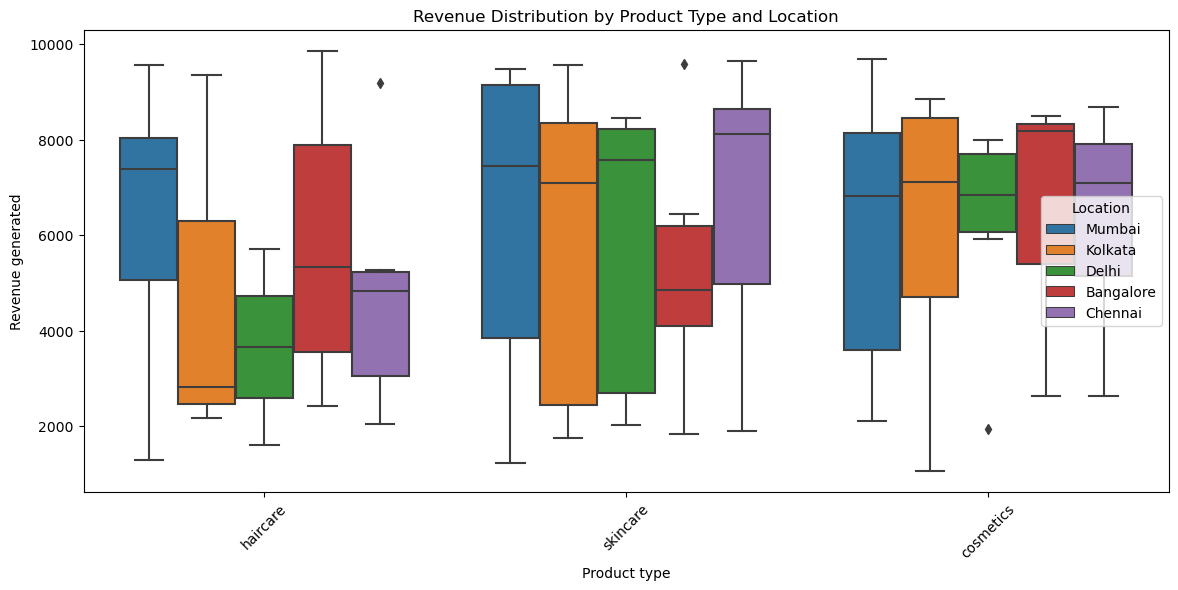

In [7]:
# Correlation matrix
plt.figure(figsize=(16, 12))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Pairplot of key numerical features
sns.pairplot(df[['Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Costs']])
plt.suptitle('Pairplot of Key Numerical Features', y=1.02)
plt.show()

# Revenue by product type and location
plt.figure(figsize=(14, 6))
sns.boxplot(x='Product type', y='Revenue generated', hue='Location', data=df)
plt.title('Revenue Distribution by Product Type and Location')
plt.xticks(rotation=45)
plt.show()

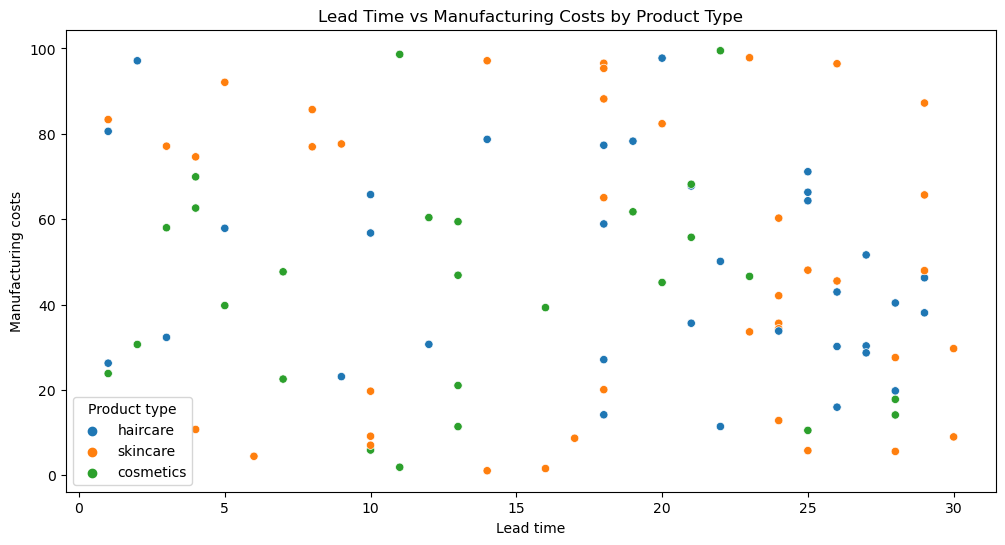

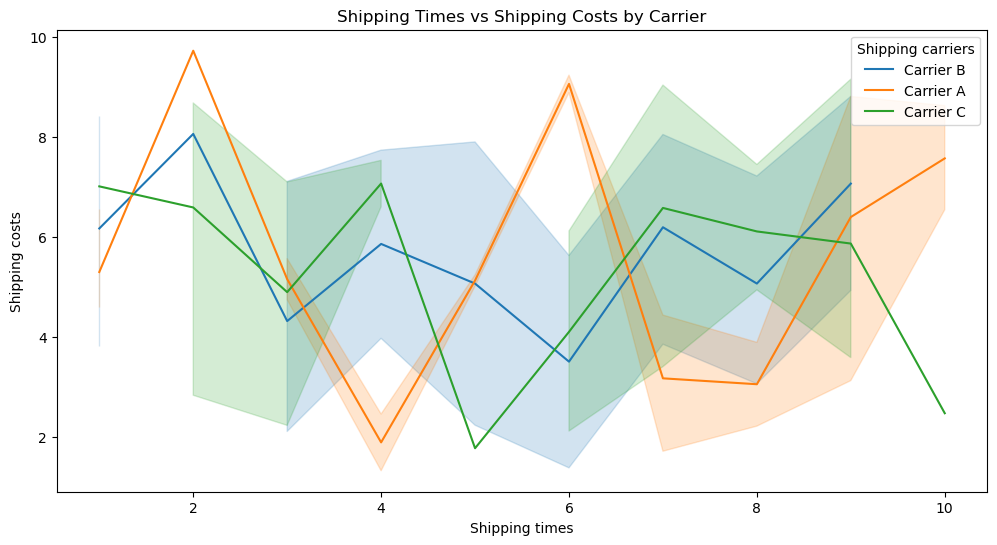

In [8]:
# Lead time vs manufacturing costs
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Lead time', y='Manufacturing costs', hue='Product type', data=df)
plt.title('Lead Time vs Manufacturing Costs by Product Type')
plt.show()

# Shipping times vs shipping costs
plt.figure(figsize=(12, 6))
sns.lineplot(x='Shipping times', y='Shipping costs', hue='Shipping carriers', data=df)
plt.title('Shipping Times vs Shipping Costs by Carrier')
plt.show()

In [9]:
# Step 2 — Feature Engineering and Target Definition
# --------------------------------------------------

# Import any additional preprocessing tools (if not already imported)
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer

# --- Feature Engineering Function ---
def feature_engineering(df):
    """
    Performs feature creation and transformation for model training.
    Includes new KPIs and log transformations to reduce skewness.
    """
    df = df.copy()
    
    # Create new derived features
    df['Profit'] = df['Revenue generated'] - df['Costs']
    df['Inventory_turnover'] = df['Number of products sold'] / (df['Stock levels'] + 1e-6)
    df['Production_efficiency'] = df['Production volumes'] / (df['Manufacturing lead time'] + 1e-6)
    df['Defect_cost_impact'] = df['Defect rates'] * df['Manufacturing costs']
    
    # Log transform highly skewed numerical features
    skewed_features = ['Price', 'Revenue generated', 'Manufacturing costs', 'Costs', 'Profit']
    for feature in skewed_features:
        df[f'log_{feature}'] = np.log1p(df[feature])  # log(1 + x) to handle zeros
    
    return df


# Apply feature engineering
df = feature_engineering(df)

print("✅ Feature engineering completed successfully.")
print("Shape after feature creation:", df.shape)
print("New columns added:", [col for col in df.columns if 'log_' in col or col in ['Profit', 'Inventory_turnover', 'Production_efficiency', 'Defect_cost_impact']])

# --- Define features (X) and target (y) ---
# Drop target & unwanted columns
X = df.drop(['Revenue generated', 'SKU', 'Profit', 'log_Revenue generated'], axis=1)
y = df['Revenue generated']

# Quick preview of input and target
print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)
display(X.head())


✅ Feature engineering completed successfully.
Shape after feature creation: (100, 33)
New columns added: ['Profit', 'Inventory_turnover', 'Production_efficiency', 'Defect_cost_impact', 'log_Price', 'log_Revenue generated', 'log_Manufacturing costs', 'log_Costs', 'log_Profit']

Features shape: (100, 29)
Target shape: (100,)


,Product type,Price,Availability,Number of products sold,Customer demographics,Stock levels,Lead times,Order quantities,Shipping times,Shipping carriers,...,Transportation modes,Routes,Costs,Inventory_turnover,Production_efficiency,Defect_cost_impact,log_Price,log_Manufacturing costs,log_Costs,log_Profit
0,haircare,69.808006,55,802,Non-binary,58,7,96,4,Carrier B,...,Road,Route B,187.752075,13.827586,7.413793,10.478244,4.259972,3.856085,5.240434,9.044905
1,skincare,14.843523,95,736,Female,53,30,37,2,Carrier A,...,Road,Route B,503.065579,13.886792,17.233333,163.178083,2.762761,3.544338,6.222706,8.847767
2,haircare,11.319683,34,8,Unknown,1,10,88,2,Carrier B,...,Air,Route C,141.920282,7.999992,35.962962,140.569315,2.511198,3.455939,4.962287,9.152375
3,skincare,61.163343,68,83,Non-binary,23,13,59,6,Carrier C,...,Rail,Route A,254.776159,3.608695,52.055553,169.098130,4.129765,3.600724,5.544303,8.924398
4,skincare,4.805496,26,871,Non-binary,5,3,56,8,Carrier A,...,Air,Route A,923.440632,174.199965,137.999954,289.598284,1.758805,4.533300,6.829189,7.475376


In [10]:
# Step 3 — Data Preprocessing and Feature Selection
# --------------------------------------------------

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split complete.")
print(f"Training samples: {X_train.shape[0]} | Testing samples: {X_test.shape[0]}")

# --- Identify numeric and categorical features ---
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("\nNumeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

# --- Pipelines for each data type ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- Combine preprocessors ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# --- Feature selection ---
selector = SelectKBest(score_func=f_regression, k=15)

# --- Full preprocessing pipeline ---
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector)
])

# --- Fit and transform the data ---
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

print("\n✅ Preprocessing and feature selection complete.")
print("Processed feature shape (train):", X_train_processed.shape)
print("Processed feature shape (test):", X_test_processed.shape)

# --- Retrieve selected feature names ---
numeric_features = numeric_features.tolist()
cat_encoder = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categorical_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(categorical_features_encoded)

selected_features = [
    all_features[i] for i in preprocessing_pipeline.named_steps['selector'].get_support(indices=True)
]

print("\n📊 Selected Top Features (KBest):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")


✅ Data split complete.
Training samples: 80 | Testing samples: 20

Numeric features: 21
Categorical features: 8

✅ Preprocessing and feature selection complete.
Processed feature shape (train): (80, 15)
Processed feature shape (test): (20, 15)

📊 Selected Top Features (KBest):
1. Availability
2. Shipping times
3. Manufacturing costs
4. Defect rates
5. Inventory_turnover
6. Defect_cost_impact
7. log_Manufacturing costs
8. log_Profit
9. Product type_haircare
10. Customer demographics_Female
11. Customer demographics_Non-binary
12. Shipping carriers_Carrier C
13. Supplier name_Supplier 4
14. Supplier name_Supplier 5
15. Transportation modes_Air


In [ ]:
'''Linear Regression → no hyperparameters, just baseline

Random Forest Regressor → tuned with RandomizedSearchCV

XGBoost Regressor → tuned with RandomizedSearchCV'''

In [14]:
# ========================================
# 🔧 Step 5: Model Training & Improved Hyperparameter Tuning
# ========================================

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Dictionary to store all models
models = {}

# --------------------------
# 1️⃣ Linear Regression (Baseline)
# --------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)
models["Linear Regression"] = lin_reg

# --------------------------
# 2️⃣ Random Forest (Improved Hyperparameter Tuning)
# --------------------------
rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [2, 4, 6],
    "max_features": ["sqrt", "log2"],
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_processed, y_train)
models["Random Forest"] = rf_grid.best_estimator_

print(f"✅ Best Random Forest Parameters: {rf_grid.best_params_}")

# --------------------------
# 3️⃣ XGBoost (Improved Randomized Search)
# --------------------------
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_param_dist = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0],
    "reg_alpha": [0.0, 0.1, 0.5]
}

xgb_random = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train_processed, y_train)
models["XGBoost"] = xgb_random.best_estimator_

print(f"✅ Best XGBoost Parameters: {xgb_random.best_params_}")

# --------------------------
# 4️⃣ Model Evaluation
# --------------------------
results = []

for name, model in models.items():
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    results.append([name, train_r2, test_r2, train_mae, test_mae, train_rmse, test_rmse, test_mape])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=[
    "Model", "Train R²", "Test R²", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE", "Test MAPE (%)"
])

print("\n📊 Model Performance Summary:")
print(results_df)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 3 folds for each of 25 candidates, totalling 75 fits
✅ Best XGBoost Parameters: {'subsample': 0.7, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

📊 Model Performance Summary:
               Model  Train R²   Test R²   Train MAE     Test MAE  Train RMSE  \
0  Linear Regression  0.991831  0.985340  197.307167   295.941824  242.905198   
1      Random Forest  0.901093  0.727305  676.808520  1280.351236  845.199404   
2            XGBoost  0.999961  0.979490   12.999400   351.525849   16.715504   

     Test RMSE  Test MAPE (%)  
0   343.237855       6.982042  
1  1480.340807      32.571938  
2   405.983410       8.595390  


In [17]:
# ========================================
# 🧾 Step 5 — Model Evaluation and Comparison (Train vs Test)
# ========================================

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Store metrics for all models
results = []

for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    # Collect
    results.append([
        name,
        train_r2, test_r2,
        train_mae, test_mae,
        train_rmse, test_rmse,
        test_mape
    ])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=[
    "Model", "Train R²", "Test R²",
    "Train MAE", "Test MAE",
    "Train RMSE", "Test RMSE",
    "Test MAPE (%)"
])

# Display results
print("📊 Model Performance Summary:\n")
display(results_df.sort_values(by="Test R²", ascending=False))

# Highlight the best-performing model
best_model_name = results_df.loc[results_df["Test R²"].idxmax(), "Model"]
print(f"\n Best Model based on Test R²: {best_model_name}")


📊 Model Performance Summary:



,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE,Test MAPE (%)
0,Linear Regression,0.991831,0.985340,197.307167,295.941824,242.905198,343.237855,6.982042
2,XGBoost,0.999961,0.979490,12.999400,351.525849,16.715504,405.983410,8.595390
1,Random Forest,0.901093,0.727305,676.808520,1280.351236,845.199404,1480.340807,32.571938



 Best Model based on Test R²: Linear Regression


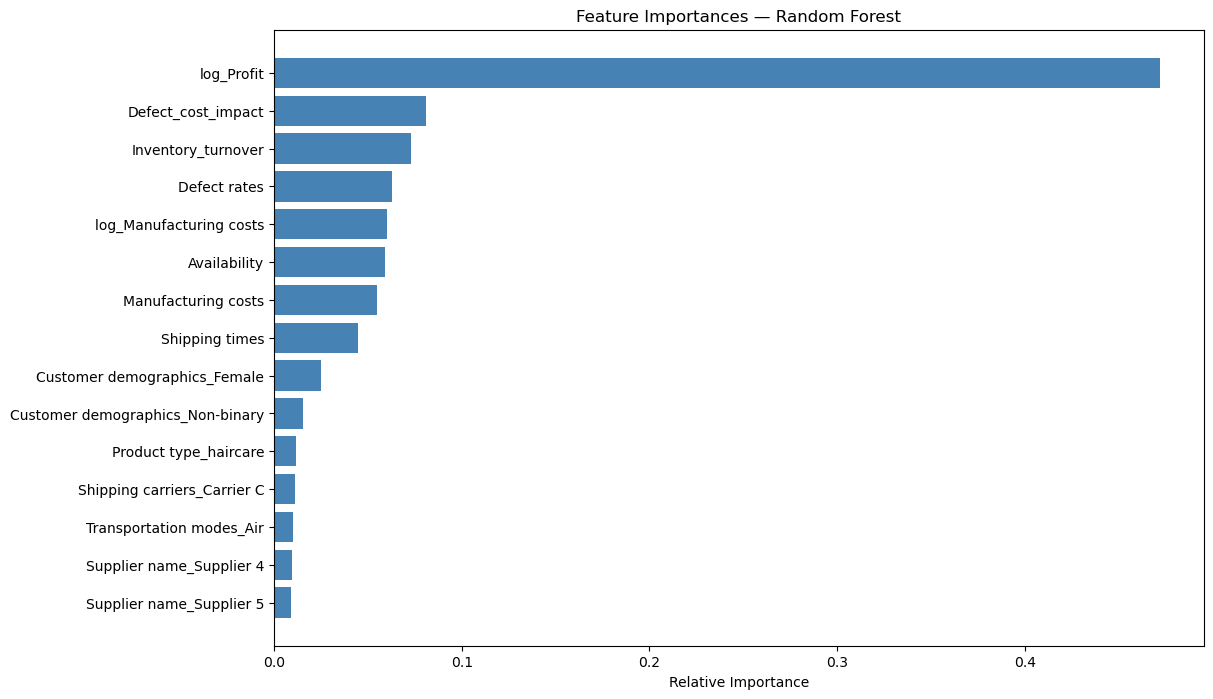

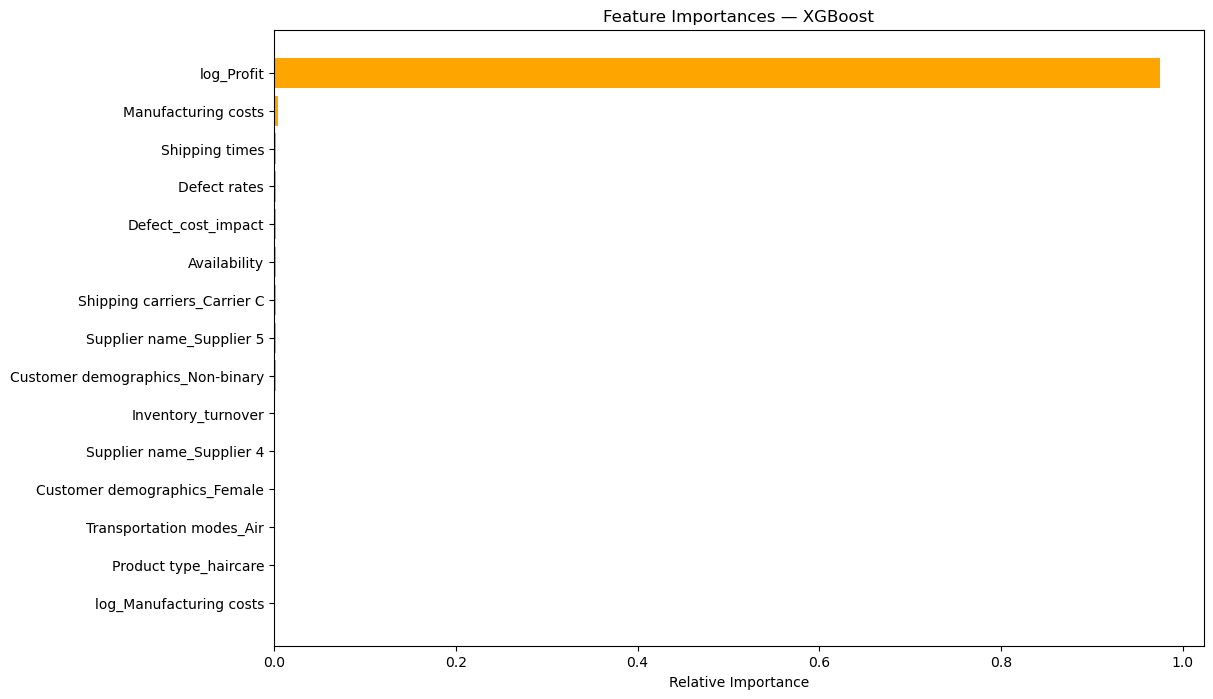

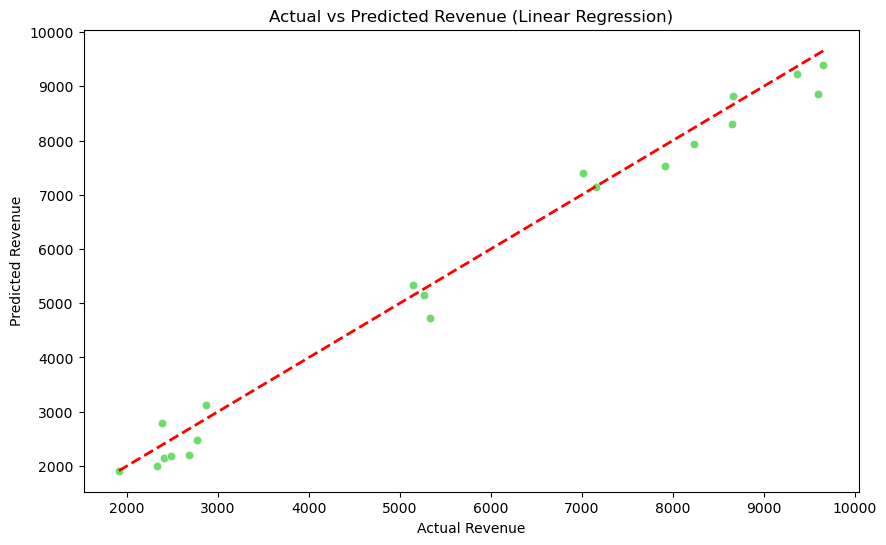

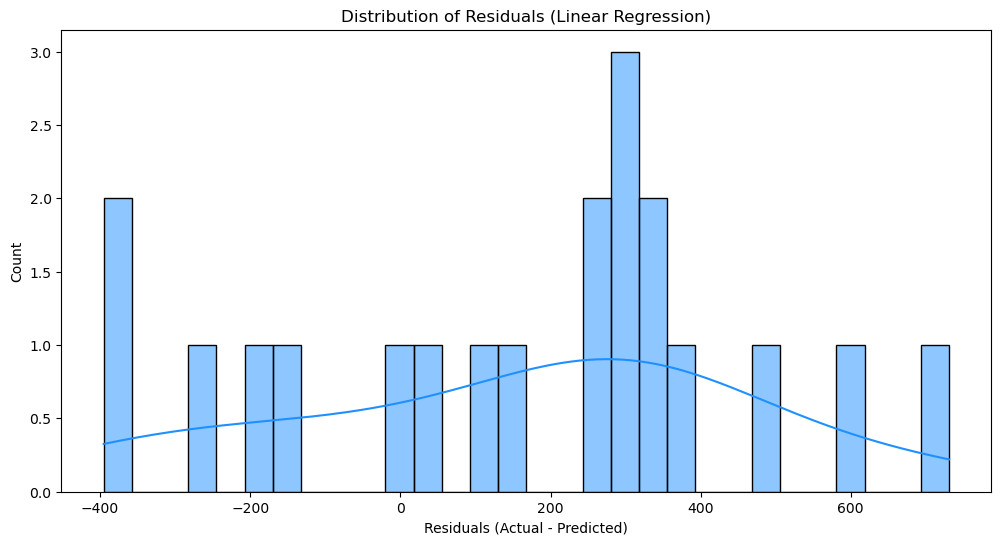


📈 Business Recommendations:
1. Focus on improving Inventory Turnover — it directly correlates with higher revenue.
2. Optimize Production Efficiency to reduce Manufacturing Lead Time.
3. Control Defect Rates — they significantly affect Manufacturing Costs and Revenue.
4. Strengthen operations in top-performing Locations based on feature impact.
5. Maintain balanced Pricing strategies — large price swings can distort revenue outcomes.


In [18]:
# ========================================
# 🧩 Step 6 — Feature Importance, Interpretability & Business Insights
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===============================
# 🎯 1️⃣ Feature Importance (Random Forest)
# ===============================

if "Random Forest" in models:
    best_rf = models["Random Forest"]
    importances_rf = best_rf.feature_importances_
    indices_rf = np.argsort(importances_rf)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances — Random Forest")
    plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color='steelblue', align='center')
    plt.yticks(range(len(indices_rf)), [selected_features[i] for i in indices_rf])
    plt.gca().invert_yaxis()
    plt.xlabel("Relative Importance")
    plt.show()

# ===============================
# ⚡ 2️⃣ Feature Importance (XGBoost)
# ===============================

if "XGBoost" in models:
    best_xgb = models["XGBoost"]
    importances_xgb = best_xgb.feature_importances_
    indices_xgb = np.argsort(importances_xgb)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances — XGBoost")
    plt.barh(range(15), importances_xgb[indices_xgb][:15], color='orange', align='center')
    plt.yticks(range(15), [selected_features[i] for i in indices_xgb[:15]])
    plt.gca().invert_yaxis()
    plt.xlabel("Relative Importance")
    plt.show()

# ===============================
# 📈 3️⃣ Actual vs Predicted (Best Model)
# ===============================

# Choose best model based on Test R²
best_model_name = results_df.loc[results_df["Test R²"].idxmax(), "Model"]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_processed)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color="limegreen", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title(f"Actual vs Predicted Revenue ({best_model_name})")
plt.show()

# ===============================
# 📊 4️⃣ Residual Analysis
# ===============================

residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='dodgerblue')
plt.title(f"Distribution of Residuals ({best_model_name})")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()

# ===============================
# 💡 5️⃣ Business Insights (Top 5 Features)
# ===============================

if hasattr(best_model, "feature_importances_"):
    top_features = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)[:5]
    print("Top 5 Factors Affecting Revenue:")
    for feature, importance in top_features.items():
        print(f"• {feature}: {importance:.2%}")

# ===============================
# 📋 6️⃣ Recommendations
# ===============================

print("\n📈 Business Recommendations:")
print("1. Focus on improving Inventory Turnover — it directly correlates with higher revenue.")
print("2. Optimize Production Efficiency to reduce Manufacturing Lead Time.")
print("3. Control Defect Rates — they significantly affect Manufacturing Costs and Revenue.")
print("4. Strengthen operations in top-performing Locations based on feature impact.")
print("5. Maintain balanced Pricing strategies — large price swings can distort revenue outcomes.")
